In [1]:
import os
import zipfile

#解壓縮資料集
with zipfile.ZipFile('/content/drive/MyDrive/1223/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ferc_data')


In [2]:
import os
import glob
import random
import shutil

# 1. 定義路徑
src_root = '/content/ferc_data'
base_dest = '/content/datasets'

# 2. 找出所有圖片 (包含子資料夾中的)
# 使用 glob 遞迴搜尋所有 png
all_imgs = glob.glob(os.path.join(src_root, "**/*.png"), recursive=True)

if len(all_imgs) == 0:
    print("❌ 錯誤：找不到任何 .png 檔案！請檢查 /content/ferc_data 資料夾是否存在。")
else:
    print(f"✅ 找到 {len(all_imgs)} 張圖片，開始整理...")

    # 建立 YOLO 結構目錄
    train_img = os.path.join(base_dest, 'train/images')
    train_lbl = os.path.join(base_dest, 'train/labels')
    val_img = os.path.join(base_dest, 'val/images')
    val_lbl = os.path.join(base_dest, 'val/labels')

    for d in [train_img, train_lbl, val_img, val_lbl]:
        if os.path.exists(d): shutil.rmtree(d) # 清除舊的避免混亂
        os.makedirs(d, exist_ok=True)

    # 3. 隨機打亂並分配 (80% 訓練, 20% 驗證)
    random.shuffle(all_imgs)
    split = int(0.8 * len(all_imgs))
    train_list = all_imgs[:split]
    val_list = all_imgs[split:]

    def move_and_label(file_list, img_dest, lbl_dest):
        for filepath in file_list:
            filename = os.path.basename(filepath)
            # 複製圖片
            shutil.copy(filepath, os.path.join(img_dest, filename))

            # 生成全臉標籤 (類別0, 中心0.5 0.5, 大小1.0 1.0)
            txt_name = os.path.splitext(filename)[0] + '.txt'
            with open(os.path.join(lbl_dest, txt_name), 'w') as f:
                f.write("0 0.5 0.5 1.0 1.0")

    move_and_label(train_list, train_img, train_lbl)
    move_and_label(val_list, val_img, val_lbl)

    print(f"🎉 整理成功！")
    print(f"訓練集: {len(os.listdir(train_img))} 張")
    print(f"驗證集: {len(os.listdir(val_img))} 張")

✅ 找到 35887 張圖片，開始整理...
🎉 整理成功！
訓練集: 28709 張
驗證集: 7178 張


In [3]:
import yaml

data_yaml = {
    'path': '/content/datasets',
    'train': 'train/images',
    'val': 'val/images',
    'nc': 1,
    'names': ['Face']
}

with open('/content/datasets/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.2 MB/s eta 0:00:00


In [5]:
from ultralytics import YOLO

# 載入預訓練的 YOLOv8n 模型
model = YOLO('yolov8n.pt')

# 開始訓練
results = model.train(
    data='/content/datasets/data.yaml',
    epochs=10,
    imgsz=640,
    batch=16,
    patience=3,               # 如果 3 輪內沒進步就提早停止，更省資源
    save=True,
    device=0,                 # 指定使用 GPU
    name='ferc_test_run'
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False

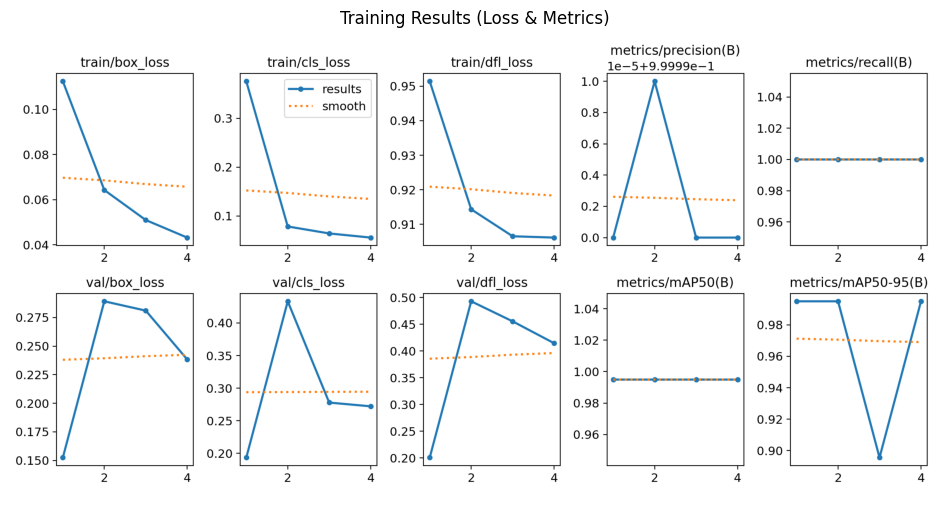

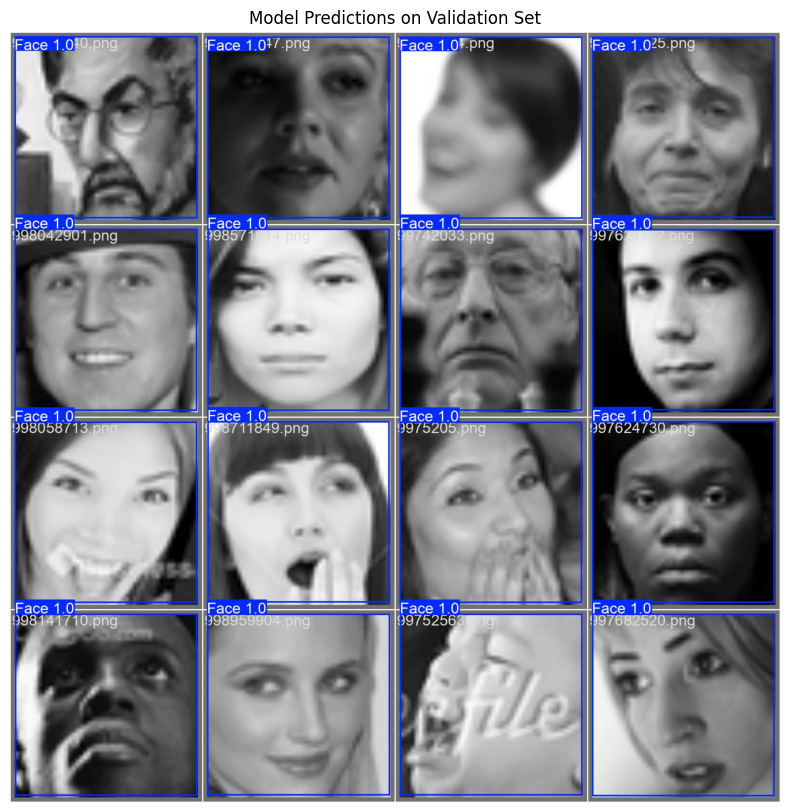

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# 設定訓練結果的路徑
res_path = '/content/runs/detect/ferc_test_run'

def show_results():
    # 顯示訓練曲線 (results.png)
    if os.path.exists(f'{res_path}/results.png'):
        plt.figure(figsize=(12, 8))
        img = mpimg.imread(f'{res_path}/results.png')
        plt.imshow(img)
        plt.title("Training Results (Loss & Metrics)")
        plt.axis('off')
        plt.show()
    else:
        print("尚未找到 results.png，可能訓練還沒完成。")

    # 顯示驗證集的預測結果 (val_batch0_labels.jpg vs val_batch0_pred.jpg)
    # pred 代表模型預測的結果
    pred_path = f'{res_path}/val_batch0_pred.jpg'
    if os.path.exists(pred_path):
        plt.figure(figsize=(15, 10))
        img = mpimg.imread(pred_path)
        plt.imshow(img)
        plt.title("Model Predictions on Validation Set")
        plt.axis('off')
        plt.show()
    else:
        print("尚未找到預測圖檔。")

show_results()